# Tutorial 1: Background and data preparation

### Outline

* Imports
* Brief discussion of xarray, intake, and zarr
* Brief discussion of ERA5, SRTM, and CMIP6 + downscaling
* Introduction to `torchdata.datapipes`
* Walk through of data processing steps
  * Subsetting to a region
  * Scaling/normalizing the data
  * Conversion between spatio-temporal dataset and ML-ready samples
  * Data splitting for train-valid-test splits
* Demonstration of the total pipeline and export to library code for next steps

In [2]:
!pip install -q zarr torchdata zen3geo dask[distributed] intake xarray fsspec aiohttp regionmask --upgrade
!pip install -q git+https://github.com/carbonplan/cmip6-downscaling.git@1.0
!pip install -q git+https://github.com/xarray-contrib/xbatcher.git@463546e7739e68b10f1ae456fb910a1628de1e5c
!pip install -q jupyterlab-vim

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cmip6-preprocessing 0.6.0 requires pint-xarray, which is not installed.
s3fs 2022.8.2 requires fsspec==2022.8.2, but you have fsspec 2023.1.0 which is incompatible.
msal-extensions 0.3.0 requires portalocker~=1.0; platform_system != "Windows", but you have portalocker 2.7.0 which is incompatible.
intake-esm 2021.8.17 requires h5netcdf>=0.8.1, but you have h5netcdf 0.0.0 which is incompatible.
geogif 0.1.3 requires dask[delayed]<2023,>=2021.4.1, but you have dask 2023.2.0 which is incompatible.
gcsfs 2022.8.2 requires fsspec==2022.8.2, but you have fsspec 2023.1.0 which is incompatible.
dask-cuda 0+untagged.46.g68c7e93.dirty requires dask==2022.03.0, but you have dask 2023.2.0 which is incompatible.
dask-cuda 0+untagged.46.g68c7e93.dirty requires distributed==2022.03.0, but you have distributed 2023.2.0 which is in

In [3]:
import os
import torch
import intake
import regionmask
import xbatcher
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings

from tqdm.autonotebook import tqdm
from functools import partial
from dask.distributed import Client, LocalCluster
from torchdata.datapipes.iter import IterDataPipe
from torch.utils.data import DataLoader

warnings.filterwarnings('ignore')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32

# Opening the data

TODO: Gonna need to clean this up and add some exposition...

In [4]:
def merge_data():
    era5_daily_cat = intake.open_esm_datastore(
        'https://cpdataeuwest.blob.core.windows.net/cp-cmip/training/ERA5-daily-azure.json'
    )
    met_files = sorted(list(era5_daily_cat.search(cf_variable_name='tasmax').df['zstore']))
    years = np.arange(1985, 2015)
    swe_files = [f'https://esiptutorial.blob.core.windows.net/eraswe/era5_raw_swe/era5_raw_swe_{year}.zarr'
             for year in years]
    swe_ds = xr.open_mfdataset(swe_files, engine='zarr')
    daily_swe = swe_ds.resample(time='1D').mean().rename({'latitude': 'lat', 'longitude': 'lon'})
    met_ds = xr.open_mfdataset(met_files,  engine='zarr')#.sel(time=swe_data['time'])
    met_ds = met_ds.sel(time=slice(daily_swe['time'].min(), daily_swe['time'].max()))
    met_ds['swe'] = daily_swe['sd']
    mask = xr.open_dataset('https://esiptutorial.blob.core.windows.net/eraswe/mask_10k_household.zarr', engine='zarr')
    terrain = xr.open_dataset('https://esiptutorial.blob.core.windows.net/eraswe/processed_slope_aspect_elevation.zarr', engine='zarr')
    met_ds['mask'] = mask['sd'].rename({'latitude': 'lat', 'longitude': 'lon'})
    met_ds = xr.merge([met_ds, terrain])
    met_ds['mask'] = np.logical_and(~np.isnan(met_ds['elevation']), met_ds['mask']>0 ).astype(int)
    return met_ds

In [6]:
ds = merge_data()
ds

<xarray.Dataset>
Dimensions:        (lat: 721, lon: 1440, time: 10957)
Coordinates:
  * lat            (lat) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon            (lon) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time           (time) datetime64[ns] 1985-01-01 1985-01-02 ... 2014-12-31
Data variables: (12/19)
    pr             (time, lat, lon) float64 dask.array<chunksize=(365, 150, 150), meta=np.ndarray>
    ps             (time, lat, lon) float32 dask.array<chunksize=(365, 150, 150), meta=np.ndarray>
    psl            (time, lat, lon) float32 dask.array<chunksize=(365, 150, 150), meta=np.ndarray>
    rsds           (time, lat, lon) float64 dask.array<chunksize=(365, 150, 150), meta=np.ndarray>
    tas            (time, lat, lon) float32 dask.array<chunksize=(365, 150, 150), meta=np.ndarray>
    tasmax         (time, lat, lon) float32 dask.array<chunksize=(365, 150, 150), meta=np.ndarray>
    ...             ...
    swe            (time, lat, lon) float32 dask.array<chunksize=(46, 91, 180), meta=np.ndarray>
    mask           (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    aspect_cosine  (lat, lon) float64 ...
    aspect_sine    (lat, lon) float64 ...
    elevation      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    slope          (lat, lon) float64 ...
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts

<GeoAxesSubplot:>

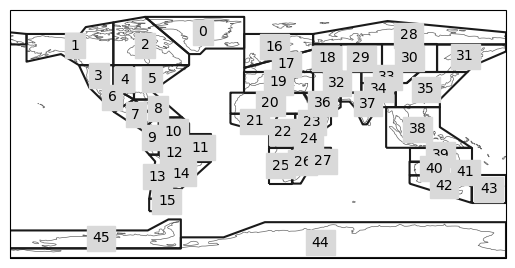

In [31]:
regionmask.defined_regions.ar6.land.plot()

# Introduction to `torchdata.datapipes`

TODO: 2 parts here - why, and how

In [13]:
class RandomNumbersPipe(IterDataPipe):
    
    def __init__(self, sample_shape, number_samples):
        super().__init__()
        self.sample_shape = sample_shape
        self.number_samples = number_samples
        
    def __iter__(self):
        for _ in range(self.number_samples):
            yield torch.randn(self.sample_shape)

In [14]:

randoms = RandomNumbersPipe(sample_shape=(5,2,), number_samples=3)
for sample in randoms:
    print(f'Shape: {sample.shape}, Mean: {torch.mean(sample)}')

Shape: torch.Size([5, 2]), Mean: -0.2451520711183548
Shape: torch.Size([5, 2]), Mean: -0.14254391193389893
Shape: torch.Size([5, 2]), Mean: -0.1228688508272171


In [15]:
def transpose(x):
    return x.T

In [29]:
randoms = RandomNumbersPipe(sample_shape=(5,2,), number_samples=3)
transposed = randoms.map(transpose)

for sample in transposed:
    print(f'Shape: {sample.shape}, Mean: {torch.mean(sample)}')

Shape: torch.Size([2, 5]), Mean: 0.12442068755626678
Shape: torch.Size([2, 5]), Mean: -0.25171002745628357
Shape: torch.Size([2, 5]), Mean: -0.1121053695678711


# The extract-transform-load (ETL) pipeline

Now that we know how to access the raw data and have a basic strategy for manipulating said data into something that can ostensibly be used for training a recurrent neural network (RNN). Our basic starting point will be to subset the global data down to a region of interest. As mentioned in other parts of the tutorial, we take this approach simply to reduce the computational workload and make it easy to run this example in an end-to-end fashion in a timely manner. To do this we will first implement a new `RegionalSubsetterPipe` class which takes the full dataset and a list of regions from the regions defined in Giorgi and Francisco (2020) and dynamically select only one region at a time. In addition to the benefit of making it easy to run this tutorial on limited time/compute, this actually has another practical benefit for running global analyses - which is that most of the gridcells in the global domain actually are not located in areas that we have flagged for snow modeling via the `mask` variable. This regional subsetting means we will have far fewer samples to filter out at training time, which will lower not only the training time but the amount of data that is ultimately transferred over the wire and processed. This type of approach, where we are using 
publicly provided, large, "analysis-ready" datasets is very useful for reproducibility, accessiblility, proof-of-concept research, and learning materials. For larger projects and mature research programs, it usually will be better to actually process the data similarly to what we do here, but save the intermediate samples out to disk/cloud storage directly and avoid the computation associated with the sampling process.

Anyhow, we can define the `RegionalSubsetterPipe` in a relatively straightforward manner, by taking in the full dataset, a sequence of the regions that are to be processed, and optionally a flag for whether to load an entire region into memory up front. The mechancs for actually selecting the region from the raw dataset is slightly involved, so we will walk through that piece in a bit more detail. First, here's the full class:

TODO: Further explanation of how the `select_region` method works....

In [38]:
class RegionalSubsetterPipe(IterDataPipe):
        
    def __init__(self, ds, selected_regions, preload=False):
        self.current_region = None
        self.ds = ds
        self.selected_regions = selected_regions
        self.preload = preload
        
    def select_region(self, region): 
        regions = regionmask.defined_regions.ar6.land
        region_id_mask = regions.mask(ds['lon'], ds['lat'])
        reg = np.unique(region_id_mask.values)
        reg = reg[~np.isnan(reg)]
        region_abbrevs = np.array(regions[reg].abbrevs)
        region_names = np.array(regions[reg].names)
        
        selection_mask = 0.0 * region_id_mask.copy()
        region_idx = np.argwhere(region_abbrevs == region)[0][0]
        region_mask = (region_id_mask == region_idx).astype(int)
        return self.ds.where(region_mask, drop=True)

    def __iter__(self):
        for region in self.selected_regions:
            if region != self.current_region:
                self.selected_ds = self.select_region(region)
                if self.preload:
                    self.selected_ds = self.selected_ds.load()
            self.current_region = region
            yield self.selected_ds

As mentioned earlier, one of the benefits of working in the data-pipe framework is we can iteratively develop and test each component of the ETL pipeline in a flexible and modular way that fits really nicely into the Jupyter workflow. To see this in action, let's actually instantiate and test if this behaves as expected!

In [42]:
r = RegionalSubsetterPipe(ds, ['WNA'])
for subset in r:
    print(subset.dims)
    print(subset.coords)

Frozen({'time': 10957, 'lat': 65, 'lon': 100})
Coordinates:
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 34.75 34.5 34.25 34.0
  * lon      (lon) float32 230.2 230.5 230.8 231.0 ... 254.2 254.5 254.8 255.0
  * time     (time) datetime64[ns] 1985-01-01 1985-01-02 ... 2014-12-31


Selecting out just the "Western North America" region (code WNA) we can see that this did indeed work. Selecting this region out yields a much smaller number of latitudes and longitudes, located exactly where we expect them. This is a good, and scalable first step to being able to process this data quickly, since this selection method is lazy and means we can reach this point with almost no actual underlying computation.

So, the next step that is reasonable to ask is: given this as our modeling domain, what does an actual "sample" consist of? Since we are still dealing with a relatively coarse spatial scale we will assume that we can neglect spatial redistribution of snow via wind and other processes. But, because snow accumulation and ablation processes can occur over long time periods we will need to account for time explicitly. That means that we will consider a single sample to be a single grid cell with some time history. We'll get a bit more into how this is actually represented in the model later, but for now we can summarize that we want to select out a single location from the model for a specified period of time. We will use the `xbatcher` python package to actually facilitate this. 

Given we have the `zen3geo` package also installed from the setup cells `xbatcher` and the `torchdata.datapipes` are already interoperable via the `pipe.slice_with_xbatcher` method.  We simply have to define some dimensions to consider a sample and we are good to go. But, before we do that, it's worth taking a moment to discuss samples versus batches. A sample is considered an individual example of the mapping that we want the model to learn. Ideally we could process all samples simultaneously to optimize our model, but as in many other areas where machine learning is common, this is computationally intractable for use. As an alternative to "full batch" processing we use the now standart approach of "mini batch" processing where we group together a small fraction of the total samples available to provide to the model and optimization routine at each update step. This is the reason that learning across large datasets is possible, and we implement this in a simple manner by grouping together nearby gridcells - often referred to as "chunks", "patches", or most commonly in the geospatial community as "chips". 

This is all handles behind the scenes by `xbatcher` simply by specifying the `batch_dims`. The time period that we consider relevant is specified via the `input_dims` argument. We consider this to be 180 days here as a "naive" choice because we have chosen our gridcells of interest to be locations where snow is common, but not present year-round in the ERA5 data. This is a "hyperparameter" that is ripe for further testing.

In [47]:
input_dims={'time': 180}
batch_dims={'lat': 30, 'lon': 30}
input_overlap={'time': 45}

pipe = RegionalSubsetterPipe(ds, ['WNA'])
pipe = pipe.slice_with_xbatcher(
    input_dims=input_dims,
    batch_dims=batch_dims,
    input_overlap=input_overlap,
    preload_batch=False
)
for batch in pipe:
    b = batch
    break
    
b

<xarray.Dataset>
Dimensions:        (time: 180, sample: 900)
Coordinates:
  * time           (time) datetime64[ns] 1985-01-01 1985-01-02 ... 1985-06-29
  * sample         (sample) object MultiIndex
  * lat            (sample) float32 50.0 50.0 50.0 50.0 ... 42.75 42.75 42.75
  * lon            (sample) float32 230.2 230.5 230.8 ... 237.0 237.2 237.5
Data variables: (12/19)
    pr             (sample, time) float64 dask.array<chunksize=(900, 180), meta=np.ndarray>
    ps             (sample, time) float32 dask.array<chunksize=(900, 180), meta=np.ndarray>
    psl            (sample, time) float32 dask.array<chunksize=(900, 180), meta=np.ndarray>
    rsds           (sample, time) float64 dask.array<chunksize=(900, 180), meta=np.ndarray>
    tas            (sample, time) float32 dask.array<chunksize=(900, 180), meta=np.ndarray>
    tasmax         (sample, time) float32 dask.array<chunksize=(900, 180), meta=np.ndarray>
    ...             ...
    swe            (sample, time) float32 dask.array<chunksize=(660, 46), meta=np.ndarray>
    mask           (sample) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    aspect_cosine  (sample) float64 nan nan nan nan ... -0.1117 -0.1347 -0.1164
    aspect_sine    (sample) float64 nan nan nan nan ... 0.02424 0.008986 -0.2774
    elevation      (sample) float64 nan nan nan nan ... 734.1 839.2 1.094e+03
    slope          (sample) float64 nan nan nan nan ... 11.36 10.05 8.716 6.84
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts

From this you can see that `xbatcher` has automatically flattened out the latitudes and longitudes into a single `sample` dimension, which willl signify to our ML model that we are ignoring spatial covariates. But, given that our selection from the `regionmask` utility is a square bounding box over the full dataset we still have to consider if all of the data in the `sample` dimension is valid. We will filter this data out with a function that removes any gridcells that do not lie within our predefined mask. This ends up being a simple boolean mask check:

In [48]:
def filter_batch(batch):
    return batch.where(batch['mask']>0, drop=True)

We can then incorporate this into our data processing pipeline simply by calling the `.map` method on our existing pipeline objects with this function as the argument. We will hold off on demonstrating this until we have completed the last two steps of the pipeline, but feel free to experiment with the final code we provide to see how this works in practice.

The next question is, given a batch of data to be fed into a model, do we need to do any "postprocessing" first? Generally it is necessary to scale data to be approximately normalized for deep-learning based models to train effectively. This is no exception in Earth/environmental science applications where inputs/covariates can often span multiple orders of magnitude. We'll use the basic standardization technique where we subtract the mean of the data and divide by the standard deviation for each variable. This sits atop an assumption that our data is somewhat normally distributed, which is certainly not true for all variables but we can get around by making some deliberate choices for scale factors.

In [32]:
def transform_batch(batch):
    scale_means = xr.Dataset()
    scale_means['mask'] = 0.0
    scale_means['swe'] = 0.0
    scale_means['pr'] = 0.00
    scale_means['tasmax'] = 295.0
    scale_means['tasmin'] = 280.0
    scale_means['elevation'] = 630.0
    scale_means['aspect_cosine'] = 0.0
    
    scale_stds = xr.Dataset()
    scale_stds['mask'] = 1.0
    scale_stds['swe'] = 3.0
    scale_stds['pr'] = 1/100.0
    scale_stds['tasmax'] = 80.0
    scale_stds['tasmin'] = 80.0
    scale_stds['elevation'] = 830.0
    scale_stds['aspect_cosine'] = 1.0
    
    batch = (batch - scale_means) / scale_stds
    return batch

Nice - we're almost there! Last thing we have to do is actually split the data out into our inputs/outputs. This point is where we have to actually come face-to-face with the data and finally get it into the format that the ML model expects.

TODO: Finish

In [32]:
def stack_split_convert(
    batch, 
    in_vars, 
    out_vars, 
    in_selectors={},
    out_selectors={},
    device=None,
    min_samples=200
):
    if len(batch['sample']) > min_samples:
        x = (batch[in_vars]
                 .to_array()
                 .transpose('sample', 'time', 'variable')
                 .isel(**in_selectors))
        y = (batch[out_vars]
                  .to_array()
                  .transpose('sample', 'time', 'variable')
                  .isel(**out_selectors))
        x = torch.tensor(x.values).float()
        y = torch.tensor(y.values).float()
        if device:
            x = x.to(device)
            y = y.to(device)
    else:
        x, y = torch.tensor([]), torch.tensor([])
    return x, y

In [ ]:
in_vars = ['pr',  'tasmax',  'tasmin',  'elevation',  'aspect_cosine']
out_vars = ['swe']
varlist = ['mask'] + in_vars + out_vars
input_sequence_length = 180  
output_sequence_length = 1
output_selector = {'time': slice(-output_sequence_length, None)}
input_dims={'time': input_sequence_length}
batch_dims={'lat': 30, 'lon': 30}
input_overlap={'time': 45}
           
convert = partial(
    stack_split_convert, 
    in_vars=in_vars, 
    out_vars=out_vars, 
    out_selectors=output_selector,
    device=DEVICE
)

In [ ]:
with ProgressBar():
    pr = (ds['pr']
          .where(ds['mask'], other=np.nan)
          .mean(dim='time')
          .compute())

In [ ]:
regions = ['EEU']
#regions =      ['NWN', 'NEN', 'WCE','TIB']# 'RAR', 'TIB', 'WCA']
dp = RegionalSubsetterPipe(
    ds[varlist].sel(time=slice('1990', '1999')).astype(np.float32),
    selected_regions=regions,
    repeat_region=1,
)

eeu = next(iter(dp))

eeu.isel(time=100)['tasmax'].plot()

# Putting it all together

In [ ]:
regions = ['CNA', 'WNA', 'ENA', 'EEU', 'WSB', 'NEU']
#regions =      ['NWN', 'NEN', 'WCE','TIB']# 'RAR', 'TIB', 'WCA']
dp = RegionalSubsetterPipe(
    ds[varlist].sel(time=slice('1985', '2015')).astype(np.float32),
    selected_regions=regions,
    repeat_region=3,
)
dp = dp.slice_with_xbatcher(
    input_dims=input_dims,
    batch_dims=batch_dims,
    input_overlap=input_overlap,
    preload_batch=False
)
dp = dp.map(filter_batch)
dp = dp.map(transform_batch)
dp = dp.map(convert)